In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
import nltk
import torch

# Download the stopwords if you haven't already
nltk.download('stopwords')

# Custom imports
from helper.helper_eda import (proportion_balance_classes, extractions_text_description, histogram_bins,
                                plot_distribution_tokens_per_word, dimensionality_reduction_chart_tsne,
                               components_pca_3d_chart)

# Enable code block
enable_code = False

# Inline plotting for Jupyter Notebooks
%matplotlib inline
custom_colors = ['#36CE8A', "#7436F5","#3736F4",   "#36AEF5", "#B336F5", "#f8165e", "#36709A",  "#3672F5", "#7ACE5D"]
gradient_colors = [ "#36CE8A", '#7436F5']
color_palette_custom  = sns.set_palette(custom_colors)
theme_color = sns.color_palette(color_palette_custom, 9)
cmap_theme = LinearSegmentedColormap.from_list('custom_colormap', gradient_colors)

# File paths
Url_fake = 'dataset/Fake.csv'
Url_true = 'dataset/True.csv'
theme_color

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanns\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanns\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[(0.21176470588235294, 0.807843137254902, 0.5411764705882353),
 (0.4549019607843137, 0.21176470588235294, 0.9607843137254902),
 (0.21568627450980393, 0.21176470588235294, 0.9568627450980393),
 (0.21176470588235294, 0.6823529411764706, 0.9607843137254902),
 (0.7019607843137254, 0.21176470588235294, 0.9607843137254902),
 (0.9725490196078431, 0.08627450980392157, 0.3686274509803922),
 (0.21176470588235294, 0.4392156862745098, 0.6039215686274509),
 (0.21176470588235294, 0.4470588235294118, 0.9607843137254902),
 (0.47843137254901963, 0.807843137254902, 0.36470588235294116)]

# Importation and preprocessing

We will be joining the dataset, for that we will take into account that we will be using the fake dataset for 1 as a target and for the true values as 0, meaning that if if the new its fake we will be adding a 1, this will help us to stratify the content so we can start we the EDA and for further experimentation.

In [2]:
df_fake_dataset = pd.read_csv(Url_true)
df_fake_dataset['target_variable'] = 1
df_true_dataset = pd.read_csv(Url_fake)
df_true_dataset['target_variable'] = 0

df_join_concat = pd.concat([df_true_dataset, df_fake_dataset], axis = 0)
print(df_true_dataset.shape)
print(df_fake_dataset.shape)
print(df_join_concat.shape)
df_join_concat.sample(3)

(23481, 5)
(21417, 5)
(44898, 5)


title  \
4802   Trump Surrogate Warns Of ‘Taco Trucks On Ever...   
4641   Former KKK Leader Thanks Trump’s VP For Being...   
6881  U.S. courts look ahead to Trump as Obama cases...   

                                                   text       subject  \
4802  MSNBC s Joy Reid filled on All In With Chris H...          News   
4641  The most infamous leader of the Ku Klux Klan h...          News   
6881  WASHINGTON (Reuters) - President Barack Obama’...  politicsNews   

                    date  target_variable  
4802   September 2, 2016                0  
4641  September 13, 2016                0  
6881   December 6, 2016                 1

Verify the types of the columns

In [3]:
df_join_concat.dtypes

title              object
text               object
subject            object
date               object
target_variable     int64
dtype: object

We will be converting the date to the proper formate date.

In [4]:
value_counts = df_join_concat['date'].value_counts()
value_counts

date
December 20, 2017                                                                                                                                        182
December 6, 2017                                                                                                                                         166
November 30, 2017                                                                                                                                        162
November 9, 2017                                                                                                                                         158
October 13, 2017                                                                                                                                         155
                                                                                                                                                        ... 
August 6, 2016                                       

In [5]:
df_join_concat_test = df_join_concat.copy()

# extract the url
url_pattern = r'http[s]?://|www\.|\.com|\.net|\.org'
df_join_concat = df_join_concat[~df_join_concat['date'].str.contains(url_pattern, na=False)]

# split the column
df_join_concat['date'] = df_join_concat['date'].str.replace('-', ' ')

df_expantion = df_join_concat['date'].str.split(' ', expand=True)
df_join_concat = pd.concat([df_join_concat, df_expantion], axis=1)

# df_join_concat.columns = ['NAM' + str(i+1) for i in range(len(df_join_concat.columns))]
df_join_concat = df_join_concat.dropna(axis=1, how='any')
df_join_concat = df_join_concat.rename(columns={0: "month", 1: "day", 2: "year"})
df_join_concat['day'] = df_join_concat['day'].str.rstrip(',')

# delete the rows that are not valid 
print(f"before the transformation rows {df_join_concat.shape}")
df_join_concat = df_join_concat[df_join_concat['year'] != '18']
df_join_concat = df_join_concat[df_join_concat['year'] != 'Rudely']
print(f"After the transformation rows {df_join_concat.shape}")

# format the column
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12,
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
df_join_concat['month'] = df_join_concat['month'].map(month_map)
df_join_concat['day'] = pd.to_numeric(df_join_concat['day'], errors='coerce')
df_join_concat['year'] = pd.to_numeric(df_join_concat['year'], errors='coerce')
df_join_concat['date'] = pd.to_datetime(df_join_concat[['year', 'month', 'day']], errors='coerce')
print(f"Finish transformation {df_join_concat.shape}")

df_join_concat.sample(3)

before the transformation rows (44889, 8)
After the transformation rows (44853, 8)
Finish transformation (44853, 8)


title  \
7675    Bernie Sanders Releases Mini-Documentary On F...   
22450  SPECTRE OF BENGHAZI: DOJ Drops Charges Against...   
11789  Denmark no longer to automatically accept U.N....   

                                                    text    subject  \
7675   Today, Senator Bernie Sanders released a new c...       News   
22450  21st Century Wire says The US Department of Ju...    US_News   
11789  COPENHAGEN (Reuters) - Denmark will no longer ...  worldnews   

            date  target_variable  month  day  year  
7675  2016-03-05                0      3    5  2016  
22450 2016-10-05                0     10    5  2016  
11789 2017-12-20                1     12   20  2017

Now that we correct the date column we will be exploring the other to columns title and text
to understand whats happening.
but for that we need to be sure, that the data for those column its clean so we can properly used.

In [6]:
df_join_concat.isnull().sum()

title              0
text               0
subject            0
date               0
target_variable    0
month              0
day                0
year               0
dtype: int64

In [7]:
print(f"dataset samples {df_join_concat.shape}")
df_join_concat = df_join_concat.drop_duplicates(subset=["text"])
print(f"dataset clean the duplicated values from text {df_join_concat.shape}")
df_join_concat = df_join_concat.drop_duplicates(subset=["title"])
print(f"dataset clean the duplicated values from title {df_join_concat.shape}")

dataset samples (44853, 8)
dataset clean the duplicated values from text (38605, 8)
dataset clean the duplicated values from title (38229, 8)


We had 6k samples that are duplicated values so we take out them from the main data, so the model performs correctly.

In [8]:
df_join_concat = df_join_concat.dropna()
df_join_concat.shape

(38229, 8)

We wil be dropping the missing values from the dataset also for the main columns

In [9]:
print(df_join_concat.shape)
df_join_concat = df_join_concat[~df_join_concat["title"].isnull()] 
print(df_join_concat[df_join_concat["title"]==" "])
df_join_concat = df_join_concat[df_join_concat["title"]!=" "]
print(df_join_concat.shape)
df_join_concat = df_join_concat[~df_join_concat["text"].isnull()]
print(df_join_concat[df_join_concat["text"]==" "])
df_join_concat = df_join_concat[df_join_concat["text"] != " "]
print(df_join_concat.shape)
df_join_concat = df_join_concat[~df_join_concat["subject"].isnull()]
print(df_join_concat[df_join_concat["subject"]==" "])
df_join_concat = df_join_concat[df_join_concat["subject"]!=" "]
print(df_join_concat.shape)
df_join_concat = df_join_concat[~df_join_concat["date"].isnull()]
print(df_join_concat[df_join_concat["date"]==" "])
df_join_concat = df_join_concat[df_join_concat["date"]!=" "]
print(df_join_concat.shape)


(38229, 8)
Empty DataFrame
Columns: [title, text, subject, date, target_variable, month, day, year]
Index: []
(38229, 8)
                                                   title text   subject  \
10923  TAKE OUR POLL: Who Do You Think President Trum...       politics   

            date  target_variable  month  day  year  
10923 2017-05-10                0      5   10  2017  
(38228, 8)
Empty DataFrame
Columns: [title, text, subject, date, target_variable, month, day, year]
Index: []
(38228, 8)
Empty DataFrame
Columns: [title, text, subject, date, target_variable, month, day, year]
Index: []
(38228, 8)


We dont found any na or null values so we can continue, also no duplicated values were found in title and text columns

In [10]:
df_join_concat['subject'].unique() 

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'politicsNews', 'worldnews'], dtype=object)

## cleaning main text

In [11]:
df_join_concat.sample(5)

title  \
7138     Fact Checkers Clear Hillary Of ‘Big Oil Bribes’   
12389  BREAKING: GOP House Chooses More Of The Same…P...   
8583    Kevin Spacey Predicts What Would Happen If Fr...   
11097  COLLEGE PROFESSOR’S SEVERED TRUMP HEAD Paintin...   
2561   House seen passing Russia sanctions bill limit...   

                                                    text       subject  \
7138   Among the slew of baseless attacks launched ag...          News   
12389  We reported yesterday that Tea Party favorite ...      politics   
8583   House of Cards star Kevin Spacey, who plays th...          News   
11097  A painting on display at a University of Alask...      politics   
2561   WASHINGTON (Reuters) - The U.S. House of Repre...  politicsNews   

            date  target_variable  month  day  year  
7138  2016-04-02                0      4    2  2016  
12389 2016-11-15                0     11   15  2016  
8583  2016-01-23                0      1   23  2016  
11097 2017-04-20                0      4   20  2017  
2561  2017-07-25                1      7   25  2017

In [12]:
df_join_concat['non_alphanumeric_title'] = df_join_concat['title'].str.extractall(r'([^a-zA-Z0-9])')[0].groupby(level=0).apply(''.join)
df_join_concat['non_alphanumeric_title'] = df_join_concat['non_alphanumeric_title'].fillna('')
all_text = ''.join(df_join_concat['non_alphanumeric_title'])
unique_chars = set(all_text)
print(len(unique_chars))
unique_chars

59


{'\n',
 '\r',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '=',
 '?',
 '@',
 '[',
 ']',
 '_',
 '{',
 '}',
 '\xa0',
 '¡',
 '£',
 '\xad',
 '¿',
 'É',
 'à',
 'á',
 'é',
 'ë',
 'í',
 'ñ',
 'ć',
 'Ž',
 'ž',
 '\u200b',
 '\u200e',
 '–',
 '—',
 '‘',
 '’',
 '“',
 '”',
 '…',
 '\u202a',
 '\u202c',
 '′',
 '″',
 '€',
 '™',
 '\ufeff'}

In this case we will be leaving all the characters not alphanumeric the rest will replace it by a space.

In [13]:
# Define values to delete and replace
delete_values = ['\n', '\r', ' ', '#',  '%', '&', '(', ')', '*', '+', '-', '/', '=', '[', ']', '_', '{', '}', '\xa0', '¡',  '\xad', '¿',  '\u200b', '\u200e', '–', '—', '…', '\u202a', '\u202c',  '™', '\ufeff']
replace_values = {'É': 'E', 'à': 'a', 'á': 'a', 'é': 'e', 'ë': 'e', 'í': 'i', 'ñ': 'n', 'ć': 'c', 'Ž': 'Z', 'ž': 'z'}

# Replace values and delete them
for value in delete_values:
    df_join_concat['title'] = df_join_concat['title'].str.replace(value, " ", regex=False)
for key, value in replace_values.items():
    df_join_concat['title'] = df_join_concat['title'].str.replace(key, value, regex=False)

df_join_concat

title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
21411  North Korea shipments to Syria chemical arms a...   
21413  LexisNexis withdrew two products from Chinese ...   
21414  Minsk cultural hub becomes haven from authorities   
21415  Vatican upbeat on possibility of Pope Francis ...   
21416  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
0      Donald Trump just couldn t wish all Americans ...       News   
1      House Intelligence Committee Chairman Devin Nu...       News   
2      On Friday, it was revealed that former Milwauk...       News   
3      On Christmas day, Donald Trump announced that ...       News   
4      Pope Francis used his annual Christmas Day mes...       News   
...                                                  ...        ...   
21411  UNITED NATIONS (Reuters) - Two North Korean sh...  worldnews   
21413  LONDON (Reuters) - LexisNexis, a provider of l...  worldnews   
21414  MINSK (Reuters) - In the shadow of disused Sov...  worldnews   
21415  MOSCOW (Reuters) - Vatican Secretary of State ...  worldnews   
21416  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...  worldnews   

            date  target_variable  month  day  year  \
0     2017-12-31                0     12   31  2017   
1     2017-12-31                0     12   31  2017   
2     2017-12-30                0     12   30  2017   
3     2017-12-29                0     12   29  2017   
4     2017-12-25                0     12   25  2017   
...          ...              ...    ...  ...   ...   
21411 2017-08-21                1      8   21  2017   
21413 2017-08-22                1      8   22  2017   
21414 2017-08-22                1      8   22  2017   
21415 2017-08-22                1      8   22  2017   
21416 2017-08-22                1      8   22  2017   

                    non_alphanumeric_title  
0                      ’  ;    ..   ,       
1                              ..       :   
2                      ‘  ’ ..  : ' .    '  
3                      ’      ()       -:   
4                                   ' '     
...                                    ...  
21411                                : ..   
21413                                       
21414                                       
21415                         ? []          
21416     : []       “    ” -      $.       

[38228 rows x 9 columns]

We are seeing that some words at the end had some tag,
we will try to extract them to understand how much of that its include it in the data.

In [14]:
df_join_concat['last_word'] = df_join_concat['title'].str.split().str[-1]
word_counts = df_join_concat['last_word'].value_counts()
all_caps_words = word_counts[word_counts.index.str.isupper()]
all_caps_words

last_word
VIDEO        3651
TWEETS        459
DETAILS       210
IMAGE         172
TWEET         159
             ... 
BASES           1
VENEZUELA       1
WHAT?           1
EXTREMISM       1
GROUPS          1
Name: count, Length: 795, dtype: int64

Because we could see that the sample that could had does tags, are tiny,
we will not take out of them, or do any kind of transformation we will leave all this tags.

Now what we will do its the same with the text, and its where we could find the main text of the algorithm

In [15]:
pattern = r"\((.*?)\)"
df_join_concat['extracted_text_parenthesis'] = df_join_concat['text'].str.findall(pattern).apply(lambda x: ', '.join(x))
df_join_concat['extracted_text_parenthesis'].value_counts()

extracted_text_parenthesis
Reuters                                                                                                                     13021
                                                                                                                             8121
@realDonaldTrump                                                                                                              133
function(d, s, id, s, d.getElementById(id, s, js, fjs, document, 'script', 'facebook-jssdk'                                    60
ACR                                                                                                                            58
                                                                                                                            ...  
@JaydaBF, link and link, @krassenstein, @SumTomGoingOn, @JaydaBF, @CeeTheHit, @JaydaBF, @Realjmannarino, @Realjmannarino        1
@patrickwardle, @0xAmit, function(d, s, id, s, d.getElementById

We will create a new feature to understand if its a twitter following the next patter "@user"
and also if its a news agency, Reuters

In [16]:
df_join_concat['is_twitter_handle'] = df_join_concat['text'].str.contains(r"@[\w]+", regex=True, na=False)
df_join_concat['is_reuters'] = df_join_concat['text'].str.contains(r"Reuters", regex=True, na=False)
df_join_concat.sample(5)

title  \
11767  WOW! REFUGEES EXPOSED: Here’s the cold hard tr...   
10117  CHRISTIAN GROUPS FEARFUL AFTER TARGETED in Fak...   
20519  Funerals crowd cemetery of dead from massive M...   
7736   Oklahoma rejects Russian request to monitor el...   
3344   Kansas governor denounces legislature's action...   

                                                    text       subject  \
11767  Brigitte Gabriel is an intelligent and importa...      politics   
10117  CNN published a hate group map and list from t...      politics   
20519  JUCHITAN, Mexico (Reuters) - Anguished mourner...     worldnews   
7736   (Reuters) - Oklahoma voting officials have den...  politicsNews   
3344   (Reuters) - Kansas Governor Sam Brownback on W...  politicsNews   

            date  target_variable  month  day  year  \
11767 2017-01-31                0      1   31  2017   
10117 2017-08-18                0      8   18  2017   
20519 2017-09-09                1      9    9  2017   
7736  2016-10-21                1     10   21  2016   
3344  2017-06-07                1      6    7  2017   

                            non_alphanumeric_title last_word  \
11767  !  : ’       ’  …“              ,     ?” []     VIDEO   
10117                                   , '    :         CNN   
20519                             “”    ’              quake   
7736                             ,                     state   
3344                          ’       ’      '         taxes   

      extracted_text_parenthesis  is_twitter_handle  is_reuters  
11767                                         False       False  
10117                                         False       False  
20519            Reuters, 800 km              False        True  
7736                Reuters, the              False        True  
3344                     Reuters              False        True

Now we will be cleaning the unique characters from the text column

In [17]:
df_join_concat['non_alphanumeric_text'] = df_join_concat['text'].str.extractall(r'([^a-zA-Z0-9])')[0].groupby(level=0).apply(''.join)
df_join_concat['non_alphanumeric_text'] = df_join_concat['non_alphanumeric_text'].fillna('')
all_text = ''.join(df_join_concat['non_alphanumeric_text'])
unique_chars = set(all_text)
print(len(unique_chars))
unique_chars

71


{'\t',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 '\xa0',
 '\xad',
 '¯',
 '°',
 '´',
 '¿',
 'à',
 'á',
 'â',
 'ç',
 'é',
 'ê',
 'í',
 'ñ',
 'ó',
 'ô',
 'ö',
 'ú',
 'ü',
 'ā',
 'ō',
 '\u200a',
 '\u200b',
 '\u200e',
 '\u200f',
 '–',
 '—',
 '‘',
 '’',
 '“',
 '”',
 '•',
 '…',
 '☑',
 '➡',
 'ツ',
 '️'}

In [18]:
# Define values to delete and replace
delete_values = {'\t', '#', '%', '&', '(', ')', '*', '+', '-', '/', '<', '=', '>', '[', '\\', ']', '^', '_', '{', '|', '}', '~', '\xa0', '\xad', '¯', '°', '´', '\u200a', '\u200b', '\u200e', '\u200f', '–', '—', '•', '…', '☑', '➡', 'ツ', '️'}
replace_values = { 'à': 'a', 'á': 'a', 'â': 'a', 'ç': 'c', 'é': 'e', 'ê': 'e', 'í': 'i',  'ó': 'o', 'ô': 'o', 'ö': 'o', 'ú': 'u', 'ü': 'u', 'ā': 'a', 'ō': 'o'}
 
# Replace values and delete them
for value in delete_values:
    df_join_concat['text'] = df_join_concat['text'].str.replace(value, " ", regex=False)
for key, value in replace_values.items():
    df_join_concat['text'] = df_join_concat['text'].str.replace(key, value, regex=False)

df_join_concat

title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
21411  North Korea shipments to Syria chemical arms a...   
21413  LexisNexis withdrew two products from Chinese ...   
21414  Minsk cultural hub becomes haven from authorities   
21415  Vatican upbeat on possibility of Pope Francis ...   
21416  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
0      Donald Trump just couldn t wish all Americans ...       News   
1      House Intelligence Committee Chairman Devin Nu...       News   
2      On Friday, it was revealed that former Milwauk...       News   
3      On Christmas day, Donald Trump announced that ...       News   
4      Pope Francis used his annual Christmas Day mes...       News   
...                                                  ...        ...   
21411  UNITED NATIONS  Reuters    Two North Korean sh...  worldnews   
21413  LONDON  Reuters    LexisNexis, a provider of l...  worldnews   
21414  MINSK  Reuters    In the shadow of disused Sov...  worldnews   
21415  MOSCOW  Reuters    Vatican Secretary of State ...  worldnews   
21416  JAKARTA  Reuters    Indonesia will buy 11 Sukh...  worldnews   

            date  target_variable  month  day  year  \
0     2017-12-31                0     12   31  2017   
1     2017-12-31                0     12   31  2017   
2     2017-12-30                0     12   30  2017   
3     2017-12-29                0     12   29  2017   
4     2017-12-25                0     12   25  2017   
...          ...              ...    ...  ...   ...   
21411 2017-08-21                1      8   21  2017   
21413 2017-08-22                1      8   22  2017   
21414 2017-08-22                1      8   22  2017   
21415 2017-08-22                1      8   22  2017   
21416 2017-08-22                1      8   22  2017   

                    non_alphanumeric_title      last_word  \
0                      ’  ;    ..   ,          Disturbing   
1                              ..       :   Investigation   
2                      ‘  ’ ..  : ' .    '           Eye’   
3                      ’      ()       -:          IMAGES   
4                                   ' '            Speech   
...                                    ...            ...   
21411                                : ..          report   
21413                                              market   
21414                                         authorities   
21415                         ? []                 Russia   
21416     : []       “    ” -      $.                jets   

                              extracted_text_parenthesis  is_twitter_handle  \
0      @realDonaldTrump, @TalbertSwan, @calvinstowell...               True   
1                                                                     False   
2      @SheriffClarke, @SheriffClarke, @KeithLeBlanc6...               True   
3      @pbump, @_cingraham, @_cingraham, @_cingraham,...               True   
4                                                                     False   
...                                                  ...                ...   
21411                         Reuters, North Korea, SSRC              False   
21413             Reuters, Nexis and LexisNexis Academic              False   
21414                                      Reuters, MZOR              False   
21415                                            Reuters              False   
21416                                            Reuters              False   

       is_reuters                              non_alphanumeric_text  
0           False                  . ,          ,         .    

Now that we had the columns prepared,
we will finish to preparing the columns taking out the URLs from the text and title column

In [19]:
# extract the urls from the text
print(df_join_concat.shape, "samples start")
pattern = r"<[^>]+>|https?://\S+|www\.\S+"
df_join_concat['title'] = df_join_concat['title'].str.replace(pattern, "", regex=True)
df_join_concat['text'] = df_join_concat['text'].str.replace(pattern, "", regex=True)
print(f"delete the url or html rows {df_join_concat.shape}")

df_join_concat.sample(5)

(38228, 14) samples start
delete the url or html rows (38228, 14)


title  \
3063   Factbox: How Senate, House Obamacare overhaul ...   
4681    Uncovered Audio Shows LIVID Hillary Clinton A...   
6889    Watch Bill O’Reilly Lose It After A Fox News ...   
15673  Fight for grassroots democracy in Cambodia sid...   
5546   Court nominee was not commenting on Trump's tw...   

                                                    text       subject  \
3063    Reuters    After weeks of discussions behind ...  politicsNews   
4681   September 11, 2001, was not only the day of th...          News   
6889   Bill O Reilly refused to believe the findings ...          News   
15673  BATTAMBANG, Cambodia  Reuters    Sin Rozeth s ...     worldnews   
5546   WASHINGTON  Reuters    Supreme Court nominee N...  politicsNews   

            date  target_variable  month  day  year  \
3063  2017-06-22                1      6   22  2017   
4681  2016-09-11                0      9   11  2016   
6889  2016-04-15                0      4   15  2016   
15673 2017-11-05                1     11    5  2017   
5546  2017-02-09                1      2    9  2017   

                 non_alphanumeric_title last_word  \
3063        *               ():  ,        compare   
4681                     / ()    ..         VIDEO   
6889                  ’              ()     VIDEO   
15673                                ..      U.S.   
5546                      ()      ' :       House   

                              extracted_text_parenthesis  is_twitter_handle  \
3063                                             Reuters              False   
4681   former Bush Environmental Protection Agency he...              False   
6889                                                                  False   
15673                            Reuters, CNRP, CPP, NDI              False   
5546                                             Reuters              False   

       is_reuters                              non_alphanumeric_text  
3063         True               ,                        .       ...  
4681        False   , ,              ,       ,          .        ...  
6889        False                     ,          .    ,          ...  
15673        True  ,  () -                          .  --        ...  
5546         True   ,       ,                  , ,        .      ...

Now that we had the main columns clean,
we will procede to calculate different ratios and values from both columns to understand how each column in this case,
title and text are describe.
but first we will delete all the columns that we will not need them anymore.

In [20]:
df_join_concat = df_join_concat.drop(columns=[ 'month', 'day','year', 'non_alphanumeric_title', 'last_word','non_alphanumeric_text', 'extracted_text_parenthesis'])
df_join_concat.sample(2)

title  \
8274   Trump Flip Flops On Super Bowl Pick After Fin...   
5018  White House says Trump did not know Flynn was ...   

                                                   text       subject  \
8274  As usual, Donald Trump s support only goes as ...          News   
5018  WASHINGTON  Reuters    The White House said on...  politicsNews   

           date  target_variable  is_twitter_handle  is_reuters  
8274 2016-02-07                0               True       False  
5018 2017-03-10                1              False        True

In [21]:
df_add_features = extractions_text_description(df_join_concat, "title")
df_add_features = extractions_text_description(df_add_features, "text")
df_add_features.sample(5)

C:\Users\hanns\anaconda3\envs\nlp\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hanns\anaconda3\envs\nlp\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


title  \
13572  CLASSY! SNOOP DOGG Scheduled To Pimp For Hilla...   
6498   Trump picks former U.S. Senator Coats as direc...   
1431    Officials: Trump Will Only Read Security Brie...   
11994  Myanmar government says case against Reuters j...   
12176  Kellyanne Conway SHUTS DOWN ABC News Hack Geor...   

                                                    text       subject  \
13572  The big dog of has been rappers is headlining ...      politics   
6498   WASHINGTON  Reuters    President elect Donald ...  politicsNews   
1431   With the advent of print on demand and e reade...          News   
11994  YANGON  Reuters    Myanmar s civilian Presiden...     worldnews   
12176  Talking to The Hollywood Reporter, Wentworth s...      politics   

            date  target_variable  is_twitter_handle  is_reuters  \
13572 2016-07-06                0              False       False   
6498  2017-01-05                1              False        True   
1431  2017-05-17                0              False       False   
11994 2017-12-18                1              False        True   
12176 2016-12-10                0              False       False   

       title_count_each_word  title_count_unique_word  \
13572                     12                       12   
6498                      11                       11   
1431                      14                       14   
11994                      9                        9   
12176                     20                       20   

       title_count_punctuations  ...  text_total_length  text_new_line  \
13572                         1  ...               1366              0   
6498                          2  ...               4022              0   
1431                          1  ...               2391              0   
11994                         0  ...               5515              0   
12176                         0  ...               1390              0   

       text_new_small_space  text_new_medium_space  text_new_big_space  \
13572                     0                      0                   0   
6498                      0                      0                   0   
1431                      0                      0                   0   
11994                     0                      0                   0   
12176                     0                      0                   0   

       text_uppercase_words  text_question_mark  text_exclamation_mark  \
13572                    75                   0                      0   
6498                    168                   0                      0   
1431                     66                   2                      0   
11994                   225                   0                      0   
12176                    46                   0                      0   

       text_word_unique_percent  text_punctuations_percent  
13572                 66.396761                   8.097166  
6498                  56.500803                  11.717496  
1431                  59.579439                  10.280374  
11994                 48.905109                   9.071950  
12176                 66.820276                   9.216590  

[5 rows x 39 columns]

Now that we had the dataset preprocess we will continue with the next step

## join text
We will join the text from the title and the main text to had just one columns to analyse


In [22]:
df_add_features["title_text_join"] = df_add_features["title"]+ " " + df_add_features["text"]
df_add_features.sample(5)

title  \
2170    Trump Threatens ‘Rude’ Media, Whines That Rep...   
1097    WATCH: Media Critics Tear Megyn Kelly Apart F...   
7980    Trump Supporter Has Dumbest Comeback Ever Aft...   
15656  Brussels prosecutors to speak on ex Catalan le...   
16563  SOCIALISM SUCKS! STARVING VENEZUELANS Steal Ch...   

                                                    text          subject  \
2170   Donald Trump is starting another week in the W...             News   
1097   Critics are calling former Fox News host, Megy...             News   
7980   A group of Donald Trump protesters assembled o...             News   
15656  BRUSSELS  Reuters    Brussels prosecutors will...        worldnews   
16563  We recently reported on Venezuelans taking tra...  Government News   

            date  target_variable  is_twitter_handle  is_reuters  \
2170  2017-03-13                0              False       False   
1097  2017-06-18                0              False       False   
7980  2016-02-20                0              False       False   
15656 2017-11-05                1              False        True   
16563 2016-06-10                0              False       False   

       title_count_each_word  title_count_unique_word  \
2170                      13                       13   
1097                      16                       16   
7980                      10                       10   
15656                      9                        9   
16563                     11                       11   

       title_count_punctuations  ...  text_new_line  text_new_small_space  \
2170                          1  ...              0                     0   
1097                          1  ...              0                     0   
7980                          0  ...              0                     0   
15656                         0  ...              0                     0   
16563                         1  ...              0                     0   

       text_new_medium_space  text_new_big_space  text_uppercase_words  \
2170                       0                   0                    47   
1097                       0                   0                    93   
7980                       0                   0                    61   
15656                      0                   0                    32   
16563                      0                   0                     3   

       text_question_mark  text_exclamation_mark  text_word_unique_percent  \
2170                    0                      1                 63.859649   
1097                    0                      0                 55.481728   
7980                    7                      0                 64.838710   
15656                   0                      0                 75.886525   
16563                   0                      0                 93.333333   

       text_punctuations_percent  \
2170                   10.526316   
1097                    8.970100   
7980                   13.870968   
15656                  11.347518   
16563                   6.666667   

                                         title_text_join  
2170    Trump Threatens ‘Rude’ Media, Whines That Rep...  
1097    WATCH: Media Critics Tear Megyn Kelly Apart F...  
7980    Trump Supporter Has Dumbest Comeback Ever Aft...  
15656  Brussels prosecutors to speak on ex Catalan le...  
16563  SOCIALISM SUCKS! STARVING VENEZUELANS Steal Ch...  

[5 rows x 40 columns]

## Split the dataset
For this we will continue with a split of 70% for training. 15% for validation and testing, this can help us understand how the model predicts,
also we will try to apply the stratify method so the values looks kind of similar in the distribution of the results.

In [23]:
from sklearn.model_selection import train_test_split
X = df_add_features.drop('target_variable', axis=1)  
y = df_add_features['target_variable']  
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Output the shapes of the splits to confirm
print("Main dataset:", df_add_features.shape, df_add_features.shape)
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)
X_train.sample(3)

Main dataset: (38228, 40) (38228, 40)
Training set: (26759, 39) (26759,)
Validation set: (5734, 39) (5734,)
Testing set: (5735, 39) (5735,)


title  \
10942  MARTHA STEWART Makes Lewd Gesture Towards Trum...   
5573    Donald Trump’s Claim That He’s The Strongest ...   
19828  Iran's Khamenei warns U.S. against 'wrong move...   

                                                    text    subject  \
10942  Martha, Martha, Martha You re 75 years old! Ti...   politics   
5573   Donald Trump loves to brag that he is the stro...       News   
19828  DUBAI  Reuters    Iran will not be bullied by ...  worldnews   

            date  is_twitter_handle  is_reuters  title_count_each_word  \
10942 2017-05-08               True       False                     12   
5573  2016-07-06              False       False                     13   
19828 2017-09-17              False        True                     10   

       title_count_unique_word  title_count_punctuations  \
10942                       12                         1   
5573                        13                         0   
19828                       10                         5   

       title_count_words_title  ...  text_new_line  text_new_small_space  \
10942                       10  ...              0                     0   
5573                         9  ...              0                     0   
19828                        2  ...              0                     0   

       text_new_medium_space  text_new_big_space  text_uppercase_words  \
10942                      0                   0                    57   
5573                       0                   0                   100   
19828                      0                   0                   124   

       text_question_mark  text_exclamation_mark  text_word_unique_percent  \
10942                   0                      7                 70.408163   
5573                    1                      0                 54.838710   
19828                   0                      0                 54.674797   

       text_punctuations_percent  \
10942                  12.244898   
5573                   13.709677   
19828                  10.569106   

                                         title_text_join  
10942  MARTHA STEWART Makes Lewd Gesture Towards Trum...  
5573    Donald Trump’s Claim That He’s The Strongest ...  
19828  Iran's Khamenei warns U.S. against 'wrong move...  

[3 rows x 39 columns]

# EDA
Now we will be analyzing different features from the training set to understand
what’s happening in the background of the model.

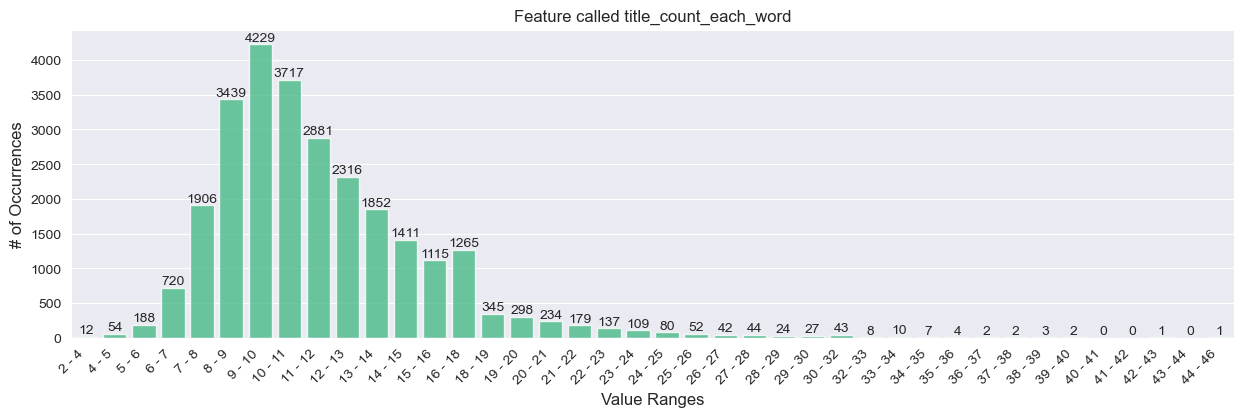

In [24]:
column_select = "title_count_each_word"
filter_data = X_train[X_train[column_select] <= 10000]
histogram_bins(filter_data[column_select].index, filter_data[column_select].values,bins= 40, title= f"Feature called {column_select}" )

We can see that for title the mean its around 40 words per sample,
so we can try to take out the outliers that can impact the inference of the model.

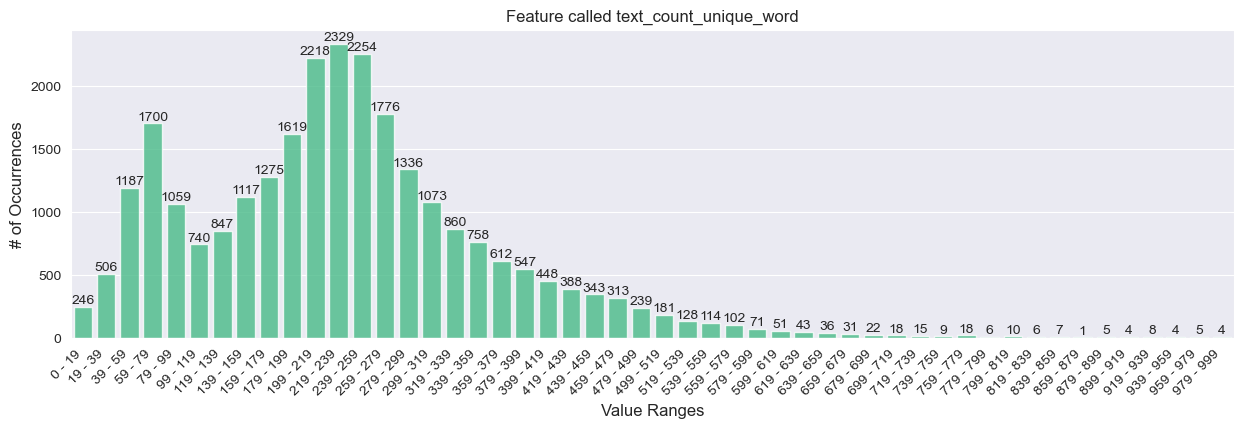

In [25]:
column_select = "text_count_unique_word" 
# we filter it because if not we will see too many outliers
filter_data = X_train[X_train[column_select] <= 1000]
histogram_bins(filter_data[column_select].index, filter_data[column_select].values,bins= 50, title= f"Feature called {column_select}" )

MMostly of the unique words are around 250 words per sample,
probably we need to understand further 
how many tokens are need it for the models and in case its need it we will need
to make some cut of the data or some adjustments for the model.

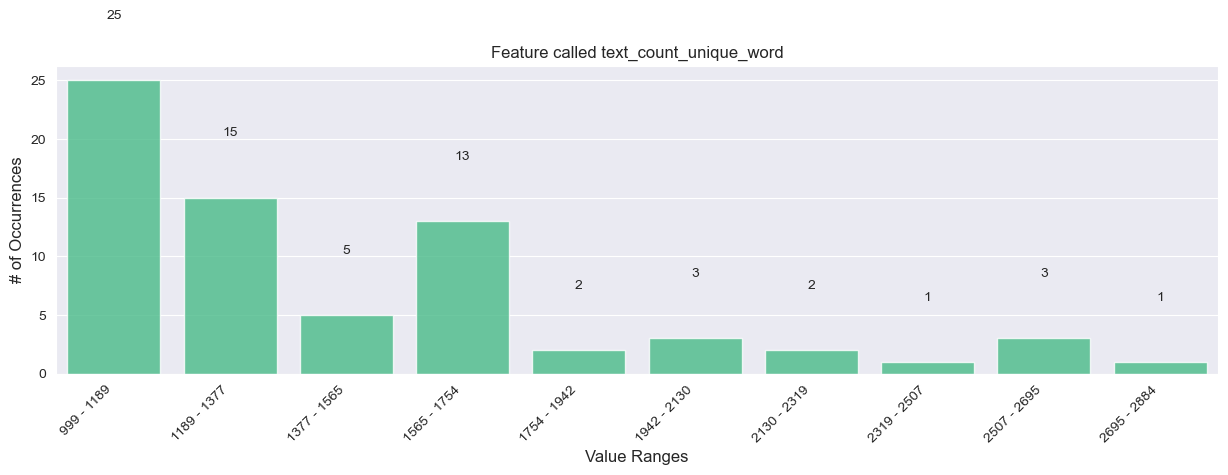

In [26]:
column_select = "text_count_unique_word" 
# we filter it because if not we will see too many outliers
filter_data = X_train[X_train[column_select] >= 1000]
histogram_bins(filter_data[column_select].index, filter_data[column_select].values,bins= 10, title= f"Feature called {column_select}" )

We had just a few samples where words are above the 1k words

In [27]:
column_select = "title_count_punctuations"
df_filter = X_train[column_select].value_counts()
print(f"we had around {round(df_filter.head(10).sum() / df_filter.sum(),4)*100} % of the data")
df_filter

we had around 100.0 % of the data


title_count_punctuations
0    9586
1    8963
2    4686
3    2261
4     840
5     320
6      81
7      19
8       3
Name: count, dtype: int64

As we can see the punctuation of the values in the titles are low,
meaning that probably its a single sentence in each title.

In [28]:
column_select = "text_count_punctuations"
df_filter = X_train[column_select].value_counts()
print(f"we had around {round(df_filter.head(10).sum() / df_filter.sum(),4)*100} % of the data")
df_filter

we had around 17.27 % of the data


text_count_punctuations
9      482
35     478
38     476
39     464
37     461
      ... 
265      1
266      1
238      1
270      1
222      1
Name: count, Length: 306, dtype: int64

It Seems that some sentences can had until 2766 points,
we need to verify what's happening, and it also seems that its huge range in the punctuation in that feature.

In [29]:
X_train.describe()

date  title_count_each_word  \
count                          26759           26759.000000   
mean   2017-02-11 08:44:31.310587136              12.131096   
min              2015-03-31 00:00:00               3.000000   
25%              2016-07-20 00:00:00              10.000000   
50%              2017-03-20 00:00:00              11.000000   
75%              2017-09-29 00:00:00              14.000000   
max              2017-12-31 00:00:00              46.000000   
std                              NaN               3.824579   

       title_count_unique_word  title_count_punctuations  \
count             26759.000000              26759.000000   
mean                 11.976232                  1.148062   
min                   3.000000                  0.000000   
25%                  10.000000                  0.000000   
50%                  11.000000                  1.000000   
75%                  14.000000                  2.000000   
max                  42.000000                  8.000000   
std                   3.665629                  1.195849   

       title_count_words_title  title_count_stopwords  title_mean_word_len  \
count             26759.000000           26759.000000         26759.000000   
mean                  6.371838               2.775814             5.446628   
min                   0.000000               0.000000             3.000000   
25%                   2.000000               1.000000             4.909091   
50%                   4.000000               2.000000             5.400000   
75%                  11.000000               4.000000             5.900000   
max                  33.000000              19.000000             9.600000   
std                   5.000883               1.921454             0.755375   

       title_total_length  title_new_line  title_new_small_space  ...  \
count        26759.000000         26759.0                26759.0  ...   
mean            76.710303             0.0                    0.0  ...   
min             15.000000             0.0                    0.0  ...   
25%             62.000000             0.0                    0.0  ...   
50%             71.000000             0.0                    0.0  ...   
75%             87.000000             0.0                    0.0  ...   
max            286.000000             0.0                    0.0  ...   
std             22.227209             0.0                    0.0  ...   

       text_total_length  text_new_line  text_new_small_space  \
count       26759.000000        26759.0               26759.0   
mean         2461.412160            0.0                   0.0   
min             2.000000            0.0                   0.0   
25%          1330.000000            0.0                   0.0   
50%          2231.000000            0.0                   0.0   
75%          3097.000000            0.0                   0.0   
max         51794.000000            0.0                   0.0   
std          1958.794281            0.0                   0.0   

       text_new_medium_space  text_new_big_space  text_uppercase_words  \
count                26759.0             26759.0          26759.000000   
mean                     0.0                 0.0             93.508614   
min                      0.0                 0.0              0.000000   
25%                      0.0                 0.0             49.000000   
50%                      0.0                 0.0             78.000000   
75%                      0.0                 0.0            115.000000   
max                      0.0                 0.0           2818.000000   
std                      0.0                 0.0             80.934083   

       text_question_mark  text_exclamation_mark  text_word_unique_percent  \
count        26759.000000           26759.000000              26758.000000   
mean             0.620165               0.368698                 63.537498   
min              0.000000               0.000000                 16.213018 

Seems that we still had a missing value in this  feature text_mean_word_len, so we will need to analyze it.
Also the ranging from 2015-03-31 to 2017-12-31, providing a span of about 2 years and 9 months.
then are several numeric values that can help us maybe to predict the results.
 

45.54 %
54.46 %


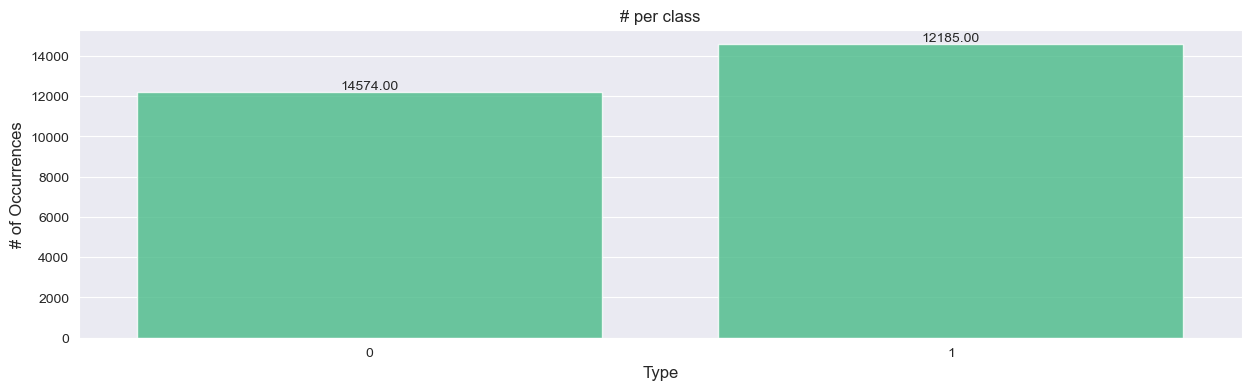

In [31]:
value_sample = y_train.value_counts() 

proportion_a = round(abs((value_sample.values[0] / sum(value_sample.values)- 1) )*100, 2 ) 
proportion_b = round(abs((value_sample.values[1] / sum(value_sample.values)- 1 ) )*100, 2 ) 
print(proportion_a, "%")
print(proportion_b , "%")
proportion_balance_classes(value_sample.index, value_sample.values)

As we can see, 54% of the news is labeled as fake (1), while 45% is labeled as not fake (0). This indicates some imbalance in the dataset. However, since the proportions are relatively close, we can consider using weights during sampling to account for this slight imbalance.

now we will be exploring some comparation with the training set
for that we will be joining the training set just for the EDA

In [32]:
# join the 2 datasets
X_train_reset_index = X_train.reset_index(drop=True) 
y_train_reset_index = y_train.reset_index(drop=True)
df_training_EDA = pd.concat([X_train_reset_index, y_train_reset_index], axis=1)
df_training_EDA.sample()

title  \
21450  Russia already preparing military withdrawal f...   

                                                    text    subject  \
21450  MOSCOW  Reuters    Russian Security Council se...  worldnews   

            date  is_twitter_handle  is_reuters  title_count_each_word  \
21450 2017-11-30              False        True                      8   

       title_count_unique_word  title_count_punctuations  \
21450                        8                         1   

       title_count_words_title  ...  text_new_small_space  \
21450                        2  ...                     0   

       text_new_medium_space  text_new_big_space  text_uppercase_words  \
21450                      0                   0                    25   

       text_question_mark  text_exclamation_mark  text_word_unique_percent  \
21450                   0                      0                 85.507246   

       text_punctuations_percent  \
21450                   7.246377   

                                         title_text_join  target_variable  
21450  Russia already preparing military withdrawal f...                1  

[1 rows x 40 columns]

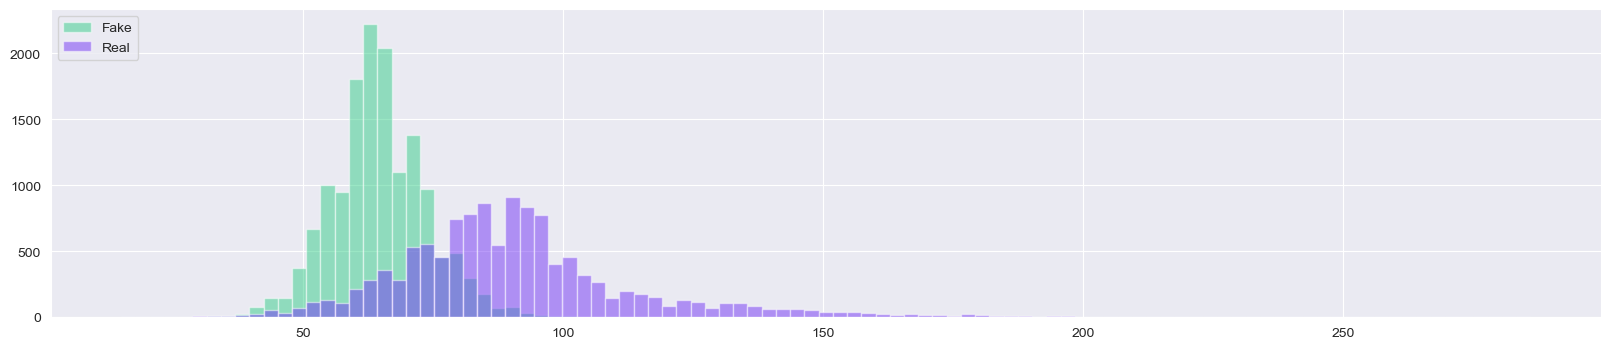

In [33]:
plt.figure(figsize=(20, 4)) 
column_analyse = "title_total_length"
bins = np.linspace(df_training_EDA[column_analyse].min(), df_training_EDA[column_analyse].max(), 100)
plt.hist(df_training_EDA[df_training_EDA["target_variable"]== 1][column_analyse], bins, alpha=0.5, label="Fake")
plt.hist(df_training_EDA[df_training_EDA["target_variable"]== 0][column_analyse], bins, alpha=0.5, label="Real")
plt.legend(loc="upper left")
plt.show()

As we can see the distribution for both features are different the more characters
we had the higher the probability that its real,
but also we are seeing that around 60 characters its where we had a lot of fake news.

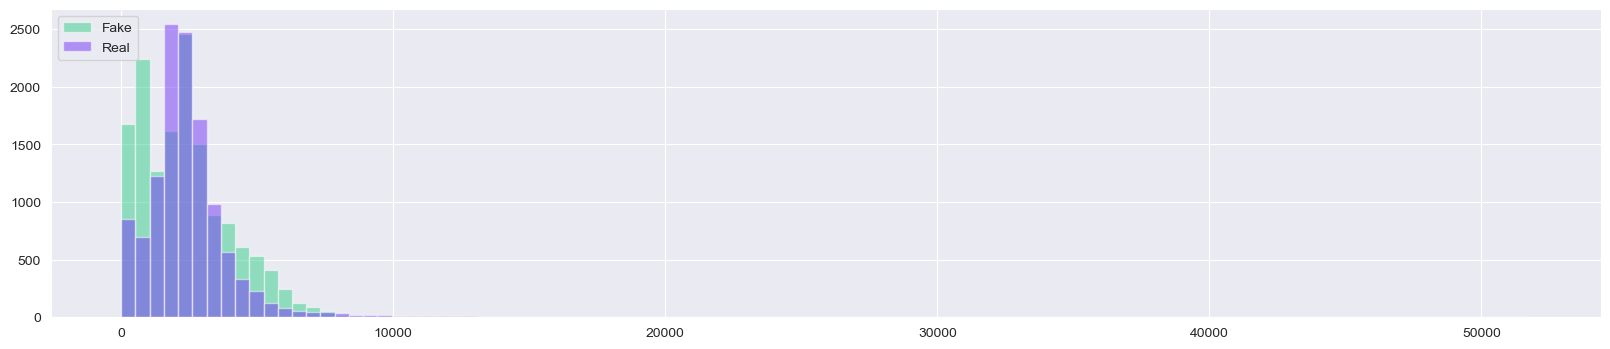

In [34]:
plt.figure(figsize=(20, 4)) 
column_analyse = "text_total_length"
bins = np.linspace(df_training_EDA[column_analyse].min(), df_training_EDA[column_analyse].max(), 100)
plt.hist(df_training_EDA[df_training_EDA["target_variable"]== 1][column_analyse], bins, alpha=0.5, label="Fake")
plt.hist(df_training_EDA[df_training_EDA["target_variable"]== 0][column_analyse], bins, alpha=0.5, label="Real")
plt.legend(loc="upper left")
plt.show()

The main text does not seems any different actually they look like they are overlapping.

12185 Real
14574 Fake


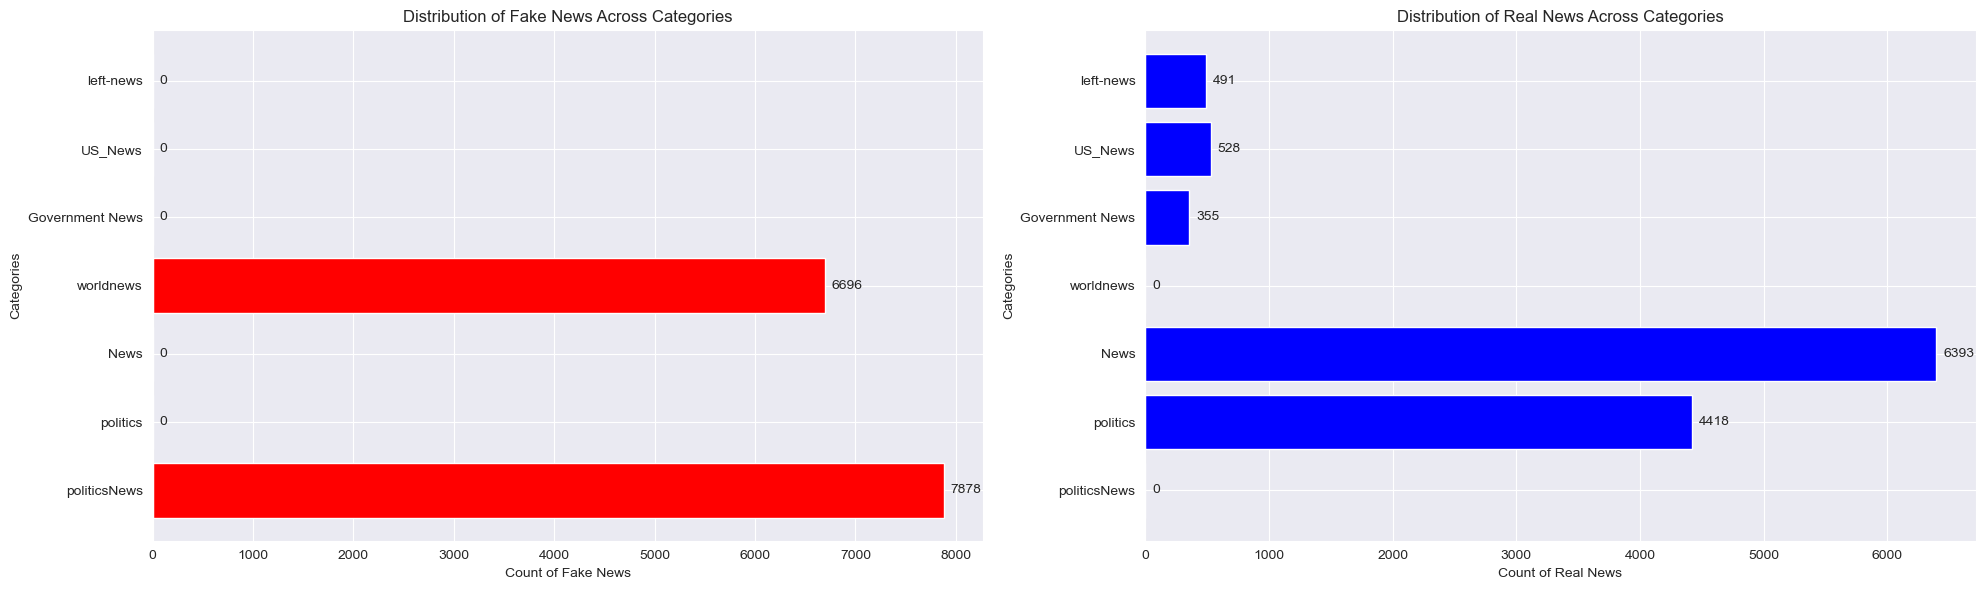

In [35]:
categories = df_training_EDA["subject"].unique()
categories = [str(category) if not pd.isna(category) else "Missing" for category in categories]  # Convert all categories to strings, handle NaN as "Missing"

fake_counts = []
real_counts = []

# Calculate the fake and real news counts for each category
for category in categories:
    if category == "Missing": 
        category_data = df_training_EDA[df_training_EDA["subject"].isna()]
    else:
        category_data = df_training_EDA[df_training_EDA["subject"] == category]
    fake_count = (category_data["target_variable"] == 1).sum()
    real_count = (category_data["target_variable"] == 0).sum()
    fake_counts.append(fake_count)
    real_counts.append(real_count)


fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Bar chart for Fake news across categories
bars_fake = axes[0].barh(categories, fake_counts, color='red')  # Add color for better distinction
axes[0].set_title("Distribution of Fake News Across Categories")
axes[0].set_xlabel('Count of Fake News')
axes[0].set_ylabel('Categories')
for bar, count in zip(bars_fake, fake_counts):
    axes[0].annotate(f'{count}', xy=(count, bar.get_y() + bar.get_height() / 2), 
                     xytext=(5, 0), textcoords="offset points", ha='left', va='center')

# Bar chart for Real news across categories
bars_real = axes[1].barh(categories, real_counts, color='blue')  # Add color for better distinction
axes[1].set_title("Distribution of Real News Across Categories")
axes[1].set_xlabel('Count of Real News')
axes[1].set_ylabel('Categories')
for bar, count in zip(bars_real, real_counts):
    axes[1].annotate(f'{count}', xy=(count, bar.get_y() + bar.get_height() / 2), 
                     xytext=(5, 0), textcoords="offset points", ha='left', va='center')

print(df_training_EDA[df_training_EDA["target_variable"] == 0]["target_variable"].count(), "Real")
print(df_training_EDA[df_training_EDA["target_variable"] == 1]["target_variable"].count(), "Fake")
# Show the charts
plt.tight_layout()
plt.show()



In this case we could see a real segmentation for the categories,
so we can say that knowing the categories we can be really sure in how we will be knowing possible news and his prediction.



Now we will be showing the most plotted word on both posibble outcomes to understand if we can guess any pattern

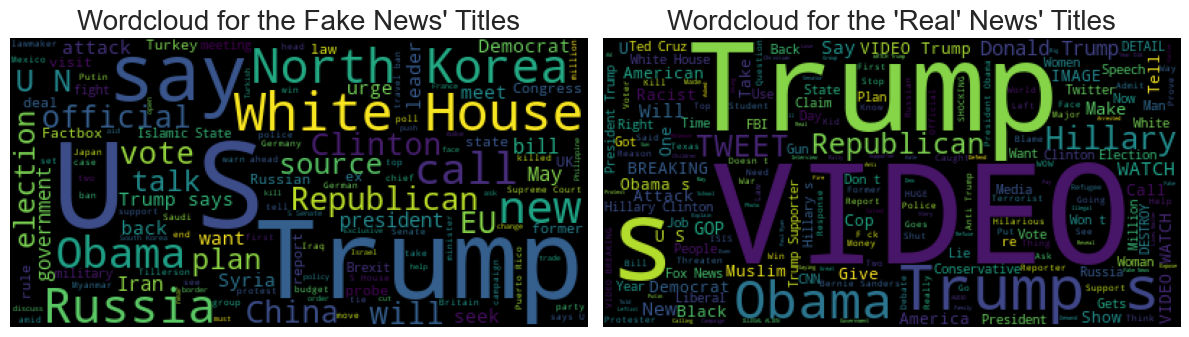

In [36]:
text_real = ' '.join(df_training_EDA.loc[df_training_EDA.target_variable == 0]['title'].map(str))
text_fake = ' '.join(df_training_EDA.loc[df_training_EDA.target_variable == 1]['title'].map(str))

wordcloud_fake = WordCloud().generate(text_fake)
wordcloud_real = WordCloud().generate(text_real)

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1.imshow(wordcloud_fake)
ax1.axis("off")
ax1.set_title("Wordcloud for the Fake News' Titles",fontsize=20)

ax2.imshow(wordcloud_real)
ax2.axis("off")
ax2.set_title("Wordcloud for the 'Real' News' Titles",fontsize=20)

plt.tight_layout()
plt.show()

Seems that Trump could be impacting in both cases,
also a lot of news seems about politics and countrys,
so we can make an educated guess that talking about this topics can be impacted by the fake news

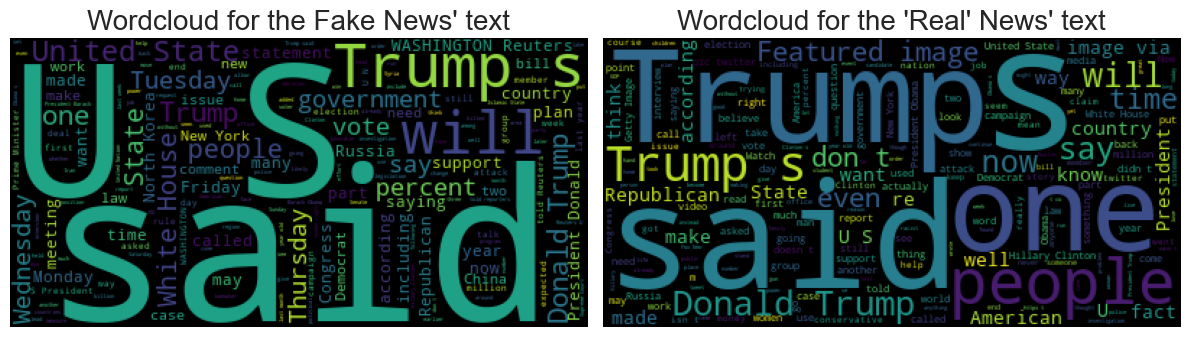

In [37]:
text_real = ' '.join(df_training_EDA.loc[df_training_EDA.target_variable == 0]['text'].map(str))
text_fake = ' '.join(df_training_EDA.loc[df_training_EDA.target_variable == 1]['text'].map(str))

wordcloud_fake = WordCloud().generate(text_fake)
wordcloud_real = WordCloud().generate(text_real)

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1.imshow(wordcloud_fake)
ax1.axis("off")
ax1.set_title("Wordcloud for the Fake News' text",fontsize=20)

ax2.imshow(wordcloud_real)
ax2.axis("off")
ax2.set_title("Wordcloud for the 'Real' News' text",fontsize=20)

plt.tight_layout()
plt.show()


In the case of the text seems the same point where they talk about country and politics

In [38]:
import plotly.express as px

# filter the date after the 2016 because we dont had data for both cases
df_training_EDA = df_training_EDA[df_training_EDA["date"] >= "2016-01-01"]

# Function to resample and count 0s and 1s (Daily Resolution Only)
def plot_time_series_daily():
    """time series analysis for the data"""
    df_resampled = df_training_EDA.groupby(df_training_EDA["date"].dt.to_period("D"))["target_variable"].value_counts().unstack(fill_value=0).reset_index()

    df_melted = df_resampled.melt(
        id_vars="date",
        value_vars=[0, 1],
        var_name="Target Value",
        value_name="Count"
    )
    df_melted["date"] = df_melted["date"].astype(str)  

    # Create the line chart
    fig = px.line(
        df_melted,
        x="date",
        y="Count",
        color="Target Value",
        title="Target Variable Count Over Time (Daily)",
        labels={"date": "Date", "Count": "Count", "Target Value": "Target Variable"}
    )
    fig.update_layout(
        xaxis_title="Days",
        yaxis_title="Count",
        showlegend=True
    )
    fig.show()

# Generate the daily resolution line chart
plot_time_series_daily()

Seems that we need to take out some values from the earlier days and use those values as just training.

## Tokenization of bert
The idea its to see how the tokenization its distributed in the two features

In [39]:
df_training_EDA.sample()

title  \
4546  Trump presidency faces longer odds after Iowa,...   

                                                   text       subject  \
4546  NEW YORK  Reuters    Republican candidate Dona...  politicsNews   

           date  is_twitter_handle  is_reuters  title_count_each_word  \
4546 2016-02-02              False        True                     10   

      title_count_unique_word  title_count_punctuations  \
4546                       10                         1   

      title_count_words_title  ...  text_new_small_space  \
4546                        2  ...                     0   

      text_new_medium_space  text_new_big_space  text_uppercase_words  \
4546                      0                   0                    79   

      text_question_mark  text_exclamation_mark  text_word_unique_percent  \
4546                   0                      0                 63.732394   

      text_punctuations_percent  \
4546                   9.507042   

                                        title_text_join  target_variable  
4546  Trump presidency faces longer odds after Iowa,...                1  

[1 rows x 40 columns]

In [40]:
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')

column_name = "title"
df_training_EDA[f"token_count_{column_name}"] = df_training_EDA[column_name].apply(  lambda x: len(tokenizer_bert.tokenize(x)) if isinstance(x, str) else 0)

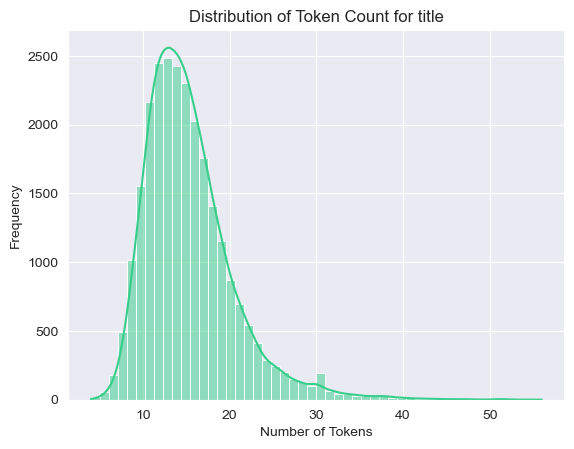

In [41]:
sns.histplot(df_training_EDA[f"token_count_{column_name}"], kde=True, bins=50)
plt.title(f"Distribution of Token Count for {column_name}")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

We could see that the distribution of the tokens its similar to the distribution of the words

In [42]:
column_name = "title"
interval_value = 32
count_below_interval_value = df_training_EDA[f"token_count_{column_name}"][df_training_EDA[f"token_count_{column_name}"] <= interval_value].count()
count_above_interval_value = df_training_EDA[f"token_count_{column_name}"][df_training_EDA[f"token_count_{column_name}"] > interval_value].count()
total_count = df_training_EDA[f"token_count_{column_name}"].count()
percent_below_interval_value = (count_below_interval_value / total_count) * 100
percent_above_interval_value = (count_above_interval_value / total_count) * 100
print(f"Count of token below < {interval_value} ({percent_below_interval_value:.2f}%)")
print(f"Count of token above > {interval_value} ({percent_above_interval_value:.2f}%)")

Count of token below < 32 (98.93%)
Count of token above > 32 (1.07%)


In this case we had less tokens for the analysing of the title

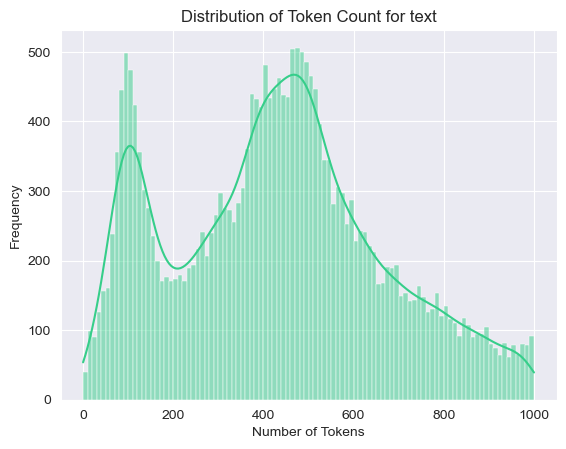

In [43]:
column_name = "text"
df_training_EDA[f"token_count_{column_name}"] = df_training_EDA[column_name].apply(  lambda x: len(tokenizer_bert.tokenize(x)) if isinstance(x, str) else 0)
sample_data = df_training_EDA[df_training_EDA[f"token_count_{column_name}"] <= 1000]
sns.histplot(sample_data[f"token_count_{column_name}"], kde=True, bins=100)
plt.title(f"Distribution of Token Count for {column_name}")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

We could see a double mode in the tokens for text, so its not a clear distribution,
meaning that we could had different zone where the values could mean differently.

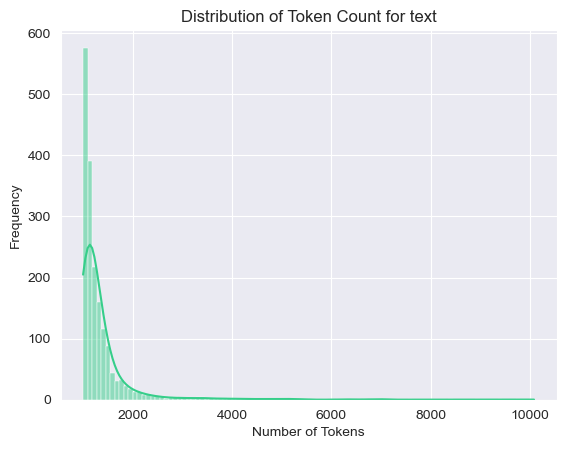

In [44]:
column_name = "text"
sample_data = df_training_EDA[df_training_EDA[f"token_count_{column_name}"] > 1000]
sns.histplot(sample_data[f"token_count_{column_name}"], kde=True, bins=100)
plt.title(f"Distribution of Token Count for {column_name}")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

Everything its skew to the right!

In [45]:
interval_value = 1024*2
count_below_interval_value = df_training_EDA[f"token_count_{column_name}"][df_training_EDA[f"token_count_{column_name}"] <= interval_value].count()
count_above_interval_value = df_training_EDA[f"token_count_{column_name}"][df_training_EDA[f"token_count_{column_name}"] > interval_value].count()
total_count = df_training_EDA[f"token_count_{column_name}"].count()
percent_below_interval_value = (count_below_interval_value / total_count) * 100
percent_above_interval_value = (count_above_interval_value / total_count) * 100
print(f"Count of token below < {interval_value} ({percent_below_interval_value:.2f}%)")
print(f"Count of token above > {interval_value} ({percent_above_interval_value:.2f}%)")

Count of token below < 2048 (99.54%)
Count of token above > 2048 (0.46%)


As we can see in the text feature all the data its below 2048 tokens.

Now we will see the distribution of the different tokens

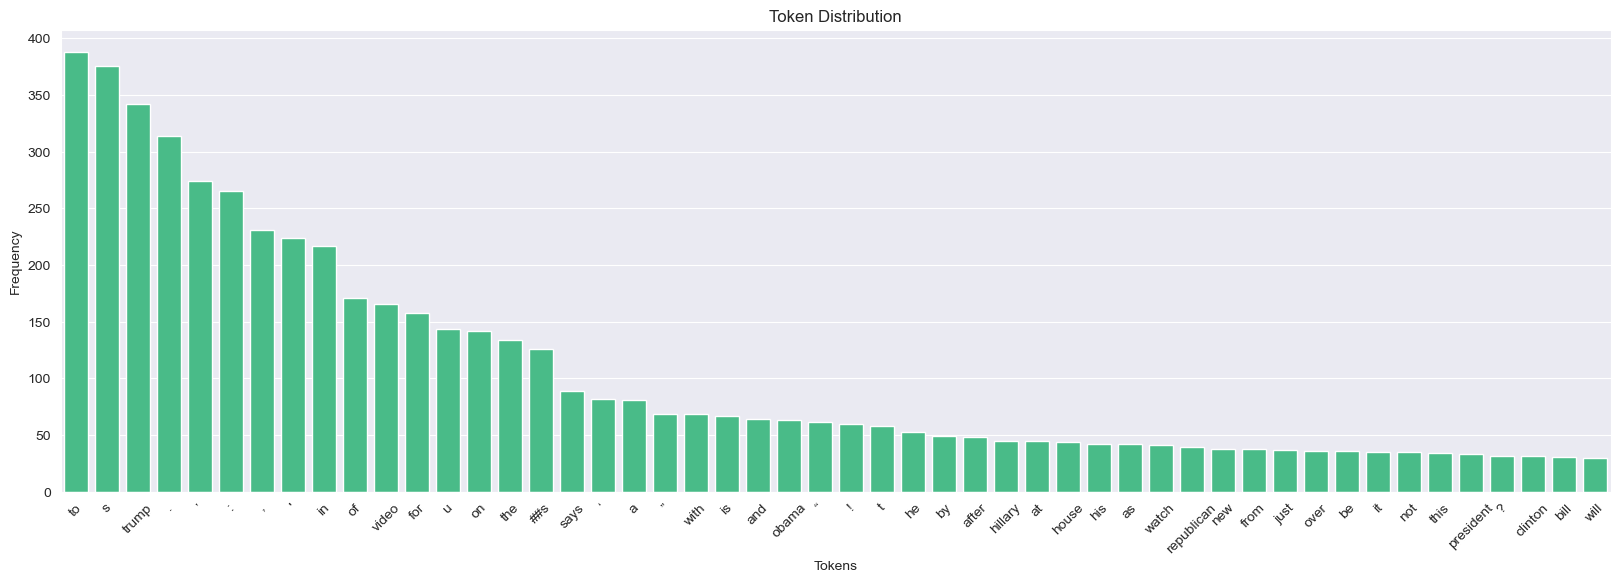

['key',
 'republican',
 'senator',
 'doubts',
 '15',
 'percent',
 'corporate',
 'tax',
 'rate',
 'can',
 'be',
 'reached',
 'rick',
 'perry',
 'is',
 'mocked',
 'over',
 'nu',
 '##kes',
 'by',
 'secretary',
 'whose',
 'job',
 'he',
 'thought',
 'he',
 'was',
 'getting',
 'morocco',
 'expresses',
 'deep',
 'concern',
 'over',
 'jerusalem',
 'decision',
 ',',
 'summons',
 'u',
 '.',
 's',
 '.',
 'charge',
 'd',
 "'",
 'affair',
 '##es',
 'fbi',
 'agent',
 'who',
 '‘',
 'found',
 'nothing',
 '’',
 'on',
 'hum',
 '##a',
 'and',
 'anthony',
 'wei',
 '##ner',
 '’',
 's',
 'laptop',
 '##s',
 'in',
 'record',
 'time',
 'right',
 'before',
 'election',
 'is',
 'same',
 'agent',
 'fired',
 'by',
 'mueller',
 'for',
 'anti',
 'trump',
 'texts',
 'texas',
 'moves',
 'toward',
 'post',
 'harvey',
 'recovery',
 ';',
 'gas',
 'prices',
 'slip',
 'indonesian',
 'court',
 'recognizes',
 'native',
 'religions',
 'in',
 'landmark',
 'ruling',
 'fact',
 '##box',
 ':',
 'u',
 '.',
 's',
 '.',
 'intel',
 'r

In [46]:
plot_distribution_tokens_per_word(
    model_tokenizer= tokenizer_bert,
    data_series = df_training_EDA["title"].sample(1000),
    number_words= 50,
    max_length=256)

We still see here that the most words are related to USA politics from a sample of 1k,
so in this case we will continue with the same idea,
meaning that we could see a lot of fake news because of the politics

Token indices sequence length is longer than the specified maximum sequence length for this model (821 > 512). Running this sequence through the model will result in indexing errors


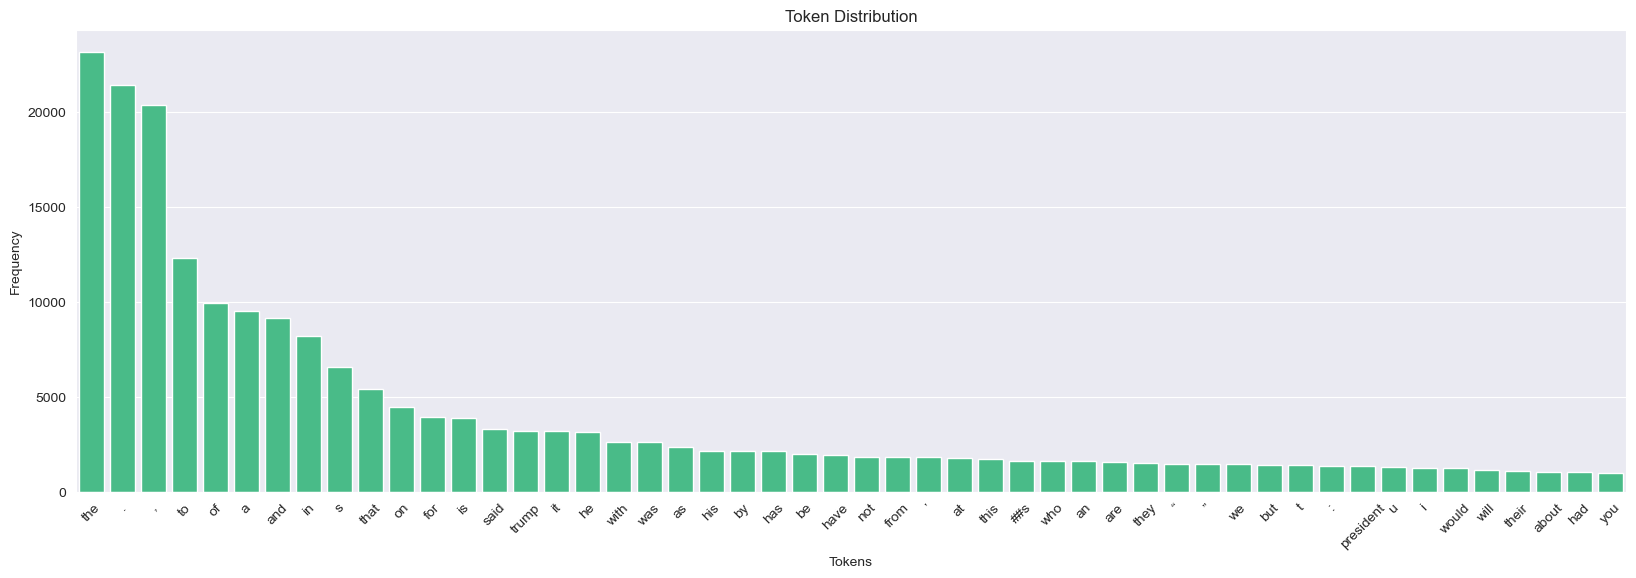

['washington',
 'boca',
 'rat',
 '##on',
 'reuters',
 'the',
 'top',
 'u',
 '.',
 's',
 '.',
 'derivatives',
 'regulator',
 'laid',
 'out',
 'plans',
 'on',
 'wednesday',
 'for',
 'a',
 'sweeping',
 'overhaul',
 'of',
 'the',
 'agency',
 'that',
 'will',
 'include',
 'everything',
 'from',
 'cutting',
 'regulation',
 'to',
 'restructuring',
 'the',
 'unit',
 'that',
 'conducts',
 'surveillance',
 'for',
 'market',
 'abuses',
 '.',
 'in',
 'a',
 'wide',
 'ranging',
 'policy',
 'speech',
 'that',
 'drew',
 'a',
 'rare',
 'standing',
 'o',
 '##vation',
 'from',
 'more',
 'than',
 '1',
 ',',
 '000',
 'industry',
 'participants',
 ',',
 'acting',
 'commodity',
 'futures',
 'trading',
 'commission',
 'chairman',
 'j',
 '.',
 'christopher',
 'gia',
 '##nca',
 '##rl',
 '##o',
 ',',
 'who',
 'was',
 'nominated',
 'by',
 'president',
 'donald',
 'trump',
 'as',
 'permanent',
 'chairman',
 'late',
 'tuesday',
 ',',
 'said',
 'it',
 'was',
 'time',
 'for',
 'the',
 'cf',
 '##tc',
 'to',
 '“',
 're

In [47]:
plot_distribution_tokens_per_word(
    model_tokenizer= tokenizer_bert,
    data_series = df_training_EDA["text"].sample(1000),
    number_words= 50,
    max_length=256)

## Word embedding

In [48]:
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')
df_training_EDA_sample = df_training_EDA.sample(1, random_state=0)
df_fake = df_training_EDA_sample[df_training_EDA_sample["target_variable"] == 1]
df_real = df_training_EDA_sample[df_training_EDA_sample["target_variable"] == 0]
df_join = pd.concat([df_fake, df_real])
df_join_text = df_join["text"].tolist()

components_pca_3d_chart(
    dataset=df_join_text, 
    tokenizer_model=tokenizer_bert,
    model_import= model_bert,
    max_length_pca= 256)

Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [49]:
df_join_text = df_join["title"].tolist()

components_pca_3d_chart(
    dataset=df_join, 
    tokenizer_model=tokenizer_bert,
    model_import= model_bert,
    max_length_pca= 256)

In both the title and text, we observe some clustering in certain areas, which suggests the presence of words with similar meanings. In the case of the title, the tokens appear to be more similar, as observed in the clustering patterns.

In [50]:
df_training_EDA_sample = df_training_EDA.sample(20, random_state=0)
df_fake = df_training_EDA_sample[df_training_EDA_sample["target_variable"] == 1]
df_real = df_training_EDA_sample[df_training_EDA_sample["target_variable"] == 0]
df_join = pd.concat([df_fake, df_real])
df_join_text = df_join["text"].tolist()

dimensionality_reduction_chart_tsne(
    text_comments= df_join_text,
    dataset= df_join,
    df_column_target= "target_variable", 
    tokenizer_model= tokenizer_bert,
    model_import= model_bert
)

As we can observe, the bot categories are rejected and located in specific zones, which suggests that the two values are likely completely different. Therefore, we can handle them separately and compress them in distinct ways, allowing us to separate the titles.

In [51]:
df_join_text = df_join["title"].tolist()

dimensionality_reduction_chart_tsne(
    text_comments= df_join_text,
    dataset= df_join,
    df_column_target= "target_variable", 
    tokenizer_model= tokenizer_bert,
    model_import= model_bert
)

In both cases, the behavior appears to be similar, exhibiting a pattern that avoids the center. This suggests that there might be distinguishable differences between the two dependent features, which could be useful for prediction.

## Export
Now that we had everything ready we will export the dataset

In [52]:
X_train.to_csv("dataset/X_train.csv", index=False)
y_train.to_csv("dataset/y_train.csv", index=False)
X_val.to_csv("dataset/X_val.csv", index=False)
y_val.to_csv("dataset/y_val.csv", index=False)
X_test.to_csv("dataset/X_test.csv", index=False)
y_test.to_csv("dataset/y_test.csv", index=False)
X_train.sample(5)

title  \
6701   How A Federal Judge Just Helped Republicans I...   
4175   Here’s The New Way Trump Is Scamming Republic...   
6830   WATCH: Fox News A Hole Spends Tax Day Shaming...   
9809  BREAKING NEWS: Controversial ALABAMA GOP Senat...   
8565  Briton in Trump gun incident could die in U.S....   

                                                   text       subject  \
6701  Republicans were just given a leg up over Demo...          News   
4175  Donald Trump has claimed to be a billionaire w...          News   
6830  Fox News  raging pile of upper one percent gar...          News   
9809  Luther Strange will likely be the first and la...      politics   
8565  LONDON  Reuters    A British man detained in t...  politicsNews   

           date  is_twitter_handle  is_reuters  title_count_each_word  \
6701 2016-04-25              False       False                     12   
4175 2016-10-15              False       False                     14   
6830 2016-04-18              False       False                     15   
9809 2017-09-26              False       False                     10   
8565 2016-08-02              False        True                     12   

      title_count_unique_word  title_count_punctuations  \
6701                       11                         0   
4175                       13                         0   
6830                       14                         1   
9809                       10                         1   
8565                       11                         3   

      title_count_words_title  ...  text_new_line  text_new_small_space  \
6701                       12  ...              0                     0   
4175                       12  ...              0                     0   
6830                       13  ...              0                     0   
9809                        6  ...              0                     0   
8565                        3  ...              0                     0   

      text_new_medium_space  text_new_big_space  text_uppercase_words  \
6701                      0                   0                    82   
4175                      0                   0                    47   
6830                      0                   0                    58   
9809                      0                   0                    98   
8565                      0                   0                    76   

      text_question_mark  text_exclamation_mark  text_word_unique_percent  \
6701                   0                      0                 60.224090   
4175                   0                      0                 65.573770   
6830                   2                      0                 57.622739   
9809                   4                      0                 55.693069   
8565                   0                      0                 57.740586   

      text_punctuations_percent  \
6701                   8.963585   
4175                   9.508197   
6830                   7.235142   
9809                  11.138614   
8565                  10.669456   

                                        title_text_join  
6701   How A Federal Judge Just Helped Republicans I...  
4175   Here’s The New Way Trump Is Scamming Republic...  
6830   WATCH: Fox News A Hole Spends Tax Day Shaming...  
9809  BREAKING NEWS: Controversial ALABAMA GOP Senat...  
8565  Briton in Trump gun incident could die in U.S....  

[5 rows x 39 columns]

# Conclusions

- The dataset is imbalanced, with approximately 46% of the values on one side. However, this imbalance is not severe, allowing us to manage it effectively by incorporating weights in our solution.  
- There are noticeable insights regarding the total length of both fake and real cases, suggesting that in most instances, the status can be inferred based on this feature.  
- By leveraging the subject category, we can attempt to detect values. Initial observations indicate that two categories on each side may be predictable using simple `if-else` statements, though further testing is required to validate this approach.  
- Similarities in word tokens indicate that the algorithm is successfully organizing tokens within the feature space, enhancing its ability to make accurate predictions.
